In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph
import statistics
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
#from umap import UMAP  
from sklearn.manifold import MDS
import seaborn as sns
from scipy.stats import pearsonr
import utils

In [12]:
D_data = pd.read_csv('data/Denmark/Merged.csv')
USA_data = pd.read_csv('data/USA/filtered_USA_votes.csv')


In [13]:
D_data['opdateringsdato_x'] = pd.to_datetime(D_data['opdateringsdato_x'],errors='coerce')

start_date = "2022-12-01"
end_date = "2025-12-31"

D_data = D_data[(D_data['opdateringsdato_x'] >= start_date) & (D_data['opdateringsdato_x'] <= end_date)]

In [14]:
D_data

,Unnamed: 0,typeid_x,afstemningid,aktørid,opdateringsdato_x,id_y,typeid_y,navn,opdateringsdato_y,startdato,slutdato,party
1672,1672,1,9004,49,2022-12-13 13:01:44.197,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1673,1673,1,9014,49,2022-12-22 09:42:26.073,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1674,1674,1,9015,49,2022-12-22 09:43:02.663,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1675,1675,1,9016,49,2022-12-22 09:44:07.067,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1676,1676,1,9017,49,2022-12-22 09:45:39.340,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
...,...,...,...,...,...,...,...,...,...,...,...,...
302093,302093,1,10110,21044,2025-01-16 17:00:16.147,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302094,302094,1,10111,21044,2025-01-23 10:01:05.520,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302095,302095,1,10112,21044,2025-01-23 10:01:33.953,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302096,302096,1,10113,21044,2025-01-23 10:02:11.817,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet


In [15]:
D_PA, D_PAV, D_PAVP, D_PP = utils.dict_create(D_data, 'aktørid','party','afstemningid','typeid_x','navn')
US_PA,US_PAV,US_PAVP,US_PP = utils.dict_create(USA_data,'icpsr','party_code','rollnumber','cast_code')


In [21]:
D_thres = np.average(utils.calc_thres(D_PP,D_PA,D_PAV))

In [22]:
edgelist = utils.edgelist_calc(D_PA,D_PAV, D_thres)
df = pd.DataFrame(edgelist, columns=["Source", "Target"])
df.to_csv("Denmark_edgelist.csv", index=False)
G_denmark = nx.from_edgelist(edgelist)

In [12]:
len(edgelist)

13314

In [13]:
list_of_dangle = [node for node in G_denmark.nodes if G_denmark.degree(node) == 0]
list_of_dangle

[]

In [23]:
U_thres = np.average(utils.calc_thres(US_PP, US_PA, US_PAV))

In [19]:
USA_inter= utils.calc_inter_edges(US_PP,US_PA,US_PAV)

In [24]:
U_edgelist = utils.edgelist_calc(US_PA, US_PAV, U_thres)
U_edgelist = (U_edgelist + USA_inter)
df = pd.DataFrame(U_edgelist, columns=["Source", "Target"])
df.to_csv("USA_edgelist.csv", index=False)
G_USA = nx.from_edgelist(U_edgelist)

In [25]:
list_of_dangle = [node for node in G_USA.nodes if G_USA.degree(node) == 0]
list_of_dangle

[]

In [17]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    100: 0,  # Democrat
    200: 1,  # Republican 
    328: 2,  # Independent
}

for icpsr in US_PAVP:
    party_code = US_PAVP[icpsr][0][2]  # Get party code from first vote
    node_to_community[icpsr] = party_to_community.get(party_code, 3)  # Default 3 for other parties

# Color mapping
community_to_color = {
    0: 'blue',      # Democrats
    1: 'red',       # Republicans
    2: 'green',     # Independents
    3: 'gray'       # Others
}
node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}



c:\Users\kubic\OneDrive\Dokumenty\envs\polarization\lib\site-packages\netgraph\_node_layout.py:1550: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
c:\Users\kubic\OneDrive\Dokumenty\envs\polarization\lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


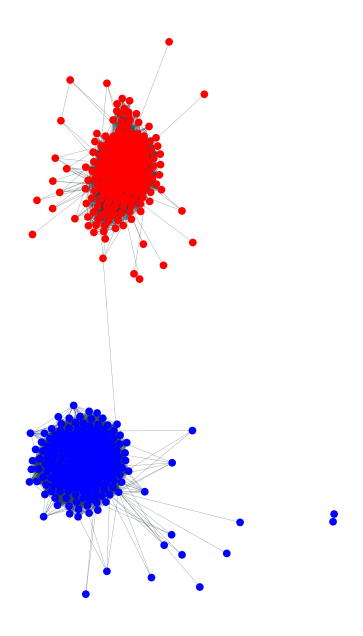

In [18]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_USA,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

In [60]:
set(D_data['party'])

{'Alternativet',
 'Borgernes Parti',
 'Danmarksdemokraterne',
 'Dansk Folkeparti',
 'Det Konservative Folkeparti',
 'Enhedslisten',
 'Liberal Alliance',
 'Moderaterne',
 'Radikale Venstre',
 'Sambandsflokkurin',
 'Siumut',
 'Socialdemokratiet',
 'Socialistisk Folkeparti',
 'Uden for folketingsgrupperne',
 'Venstre'}

In [61]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    'Alternativet': 0,  
    'Danmarksdemokraterne': 1,   
    'Dansk Folkeparti': 2,
    'Det Konservative Folkeparti': 3,
    'Enhedslisten': 4,
    'Frie Grønne': 5,
    'Liberal Alliance': 6,
    'Moderaterne': 7,
    'Radikale Venstre': 8,
    'Sambandsflokkurin': 9,
    'Siumut': 10,
    'Socialdemokratiet': 11,
    'Socialistisk Folkeparti': 12,
    'Uden for folketingsgrupperne': 13,
    'Venstre': 14,
     

}

# Color mapping
community_to_color = {
   0: 'green',
   1: 'lightblue', 
   2: 'yellow',
   3: 'darkgreen',
   4: 'orange',
   5: 'cyan',
   6: 'blue',
   7: 'magenta',
   8: 'purple',
   9: 'black',
   10: 'gray',
   11: 'red',
   12: 'pink',
   13: 'brown',
   14: 'navy'
}

node_to_community = {}
for aktor_id in PAVP:
   party_name = PAVP[aktor_id][0][2]  # Get party name from first vote
   node_to_community[aktor_id] = party_to_community.get(party_name, 0)

node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}

c:\Users\kubic\OneDrive\Dokumenty\envs\polarization\lib\site-packages\netgraph\_node_layout.py:1621: UserWarning: There are no connections within community 13. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")


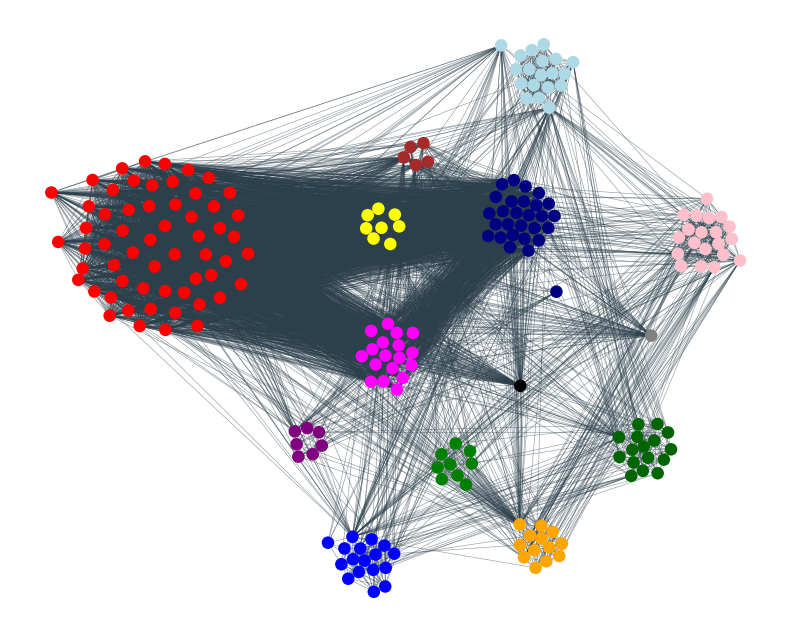

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_denmark,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

## PCA DK

In [ ]:
# Step 1: Create a list of people (rows) and their corresponding voted bills (columns)
people = list(D_PAV.keys())  # List of people (1, 2, 3, 4)
votes = set()  # Store the distinct votes/bills
for person in D_PAV:
    votes.update(D_PAV[person])  # Add all the bills that each person voted on

votes = sorted(votes)  # Sort the bills to get a consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

for person, voted_bills in D_PAV.items():
    for bill in voted_bills:
        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])   # Bill's column index
        data.append(1)  # The value in the matrix is 1 if the person voted on the bill

# Step 3: Create the sparse matrix (CSR format)
num_people = len(D_PAV)  # Number of people
num_votes = len(votes)  # Number of bills
sparse_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(num_people, num_votes))



ValueError: axis 0 index 1924 exceeds matrix dimension 220

In [312]:
sparse_matrix.T

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 112664 stored elements and shape (1925, 220)>

In [313]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 1  # You can set the number of components (dimensions) to reduce to
svd = TruncatedSVD(n_components=n_components)
D_reduced_matrix = svd.fit_transform(sparse_matrix.T)

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(D_reduced_matrix)

# Optional: You can also check the amount of variance explained by each component
print("Explained variance ratio:")
print(svd.explained_variance_ratio_)

Reduced Matrix (PCA Result):
[[8.35352995]
 [1.25807588]
 [6.6874336 ]
 ...
 [1.76581337]
 [1.72640437]
 [6.24419921]]
Explained variance ratio:
[0.26479007]


In [19]:
D_standard_reduced_matrix = (D_reduced_matrix-min(D_reduced_matrix))/(max(D_reduced_matrix)-min(D_reduced_matrix))
D_standard_reduced_matrix

array([[8.76530297e-01],
       [6.34050367e-01],
       [7.12917240e-01],
       [1.29947844e-02],
       [4.70587888e-01],
       [3.90192481e-01],
       [1.21700345e-01],
       [5.36242285e-01],
       [8.18641463e-01],
       [8.02124614e-01],
       [6.63046058e-01],
       [6.94759277e-01],
       [5.84903328e-01],
       [8.21086801e-02],
       [8.16677528e-01],
       [6.30134902e-01],
       [9.12367354e-01],
       [8.78109650e-01],
       [5.89211184e-01],
       [3.65952690e-01],
       [4.54795648e-01],
       [4.43507314e-01],
       [9.25632473e-01],
       [7.45191567e-01],
       [7.11873897e-01],
       [7.67855181e-01],
       [4.34336580e-01],
       [2.51798211e-01],
       [9.42073011e-01],
       [1.46775978e-02],
       [6.20107015e-01],
       [5.45608198e-01],
       [5.48220496e-01],
       [6.22634141e-01],
       [4.00830423e-02],
       [6.04555662e-01],
       [4.85319118e-01],
       [2.17704910e-01],
       [2.33235761e-01],
       [5.29554849e-01],


## PCA US

In [17]:
from scipy.sparse import csr_matrix

# Step 1: Extract unique people (rows) and bills (columns)
people = list(US_PAV.keys())  # List of people
votes = set()  # Store the distinct votes/bills

for voted_bills in US_PAV.values():
    for bill, _ in voted_bills:
        votes.add(bill)

votes = sorted(votes)  # Sort bills to ensure consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

for person, voted_bills in US_PAV.items():
    for bill, vote in voted_bills:  # Iterate over list of (bill, vote) pairs
        if vote == 1:
            value = 1  # Vote 1 → 0
        elif vote == 2:
            value = 0  # Vote 2 → 1
        else:
            continue  # Skip other votes

        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])  # Bill's column index
        data.append(value)  # Store transformed vote value

# Step 3: Create the sparse matrix (CSR format)
num_people_us = len(US_PAV)  # Number of people
num_votes_us = len(votes)  # Number of bills
sparse_matrix_us = csr_matrix((data, (row_indices, col_indices)), shape=(num_people_us, num_votes_us))



In [18]:
sparse_matrix_us

<451x1235 sparse matrix of type '<class 'numpy.int64'>'
	with 516591 stored elements in Compressed Sparse Row format>

In [38]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 2  # You can set the number of components (dimensions) to reduce to
pca = PCA(n_components=n_components)
US_reduced_matrix= pca.fit_transform(sparse_matrix_us)

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(US_reduced_matrix)

# Optional: You can also check the amount of variance explained by each component
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

Reduced Matrix (PCA Result):
[[ 1.01299413e+01  3.52721296e+00]
 [ 1.13761931e+01  3.17080347e+00]
 [-1.22956497e+01  9.38077579e-01]
 [-1.20317554e+01  2.67587711e+00]
 [-1.37383498e+01 -5.89856462e-02]
 [-1.35763449e+01 -5.60101105e-01]
 [-1.35091818e+01  1.32232521e+00]
 [-1.39275175e+01  4.79104569e-01]
 [-1.34054655e+01  2.16546294e-01]
 [ 1.29185973e+01  2.21298831e+00]
 [-1.31220860e+01  1.79426743e+00]
 [-1.39576149e+01  9.04578760e-01]
 [ 1.34331576e+01  2.27573440e+00]
 [ 1.42870568e+01  1.41715145e+00]
 [-1.35851449e+01  9.67070130e-01]
 [ 1.26161791e+01  3.33994479e+00]
 [-1.19947986e+01 -8.65754567e+00]
 [-1.38572573e+01  3.90355285e-01]
 [ 9.97122377e+00  2.68773592e+00]
 [-1.25985624e+01  2.05106944e+00]
 [-1.27750698e+01  2.04247302e+00]
 [-1.35181307e+01  7.68193139e-01]
 [ 8.46013319e+00  4.89145018e+00]
 [ 1.02403744e+01  4.58729230e+00]
 [ 1.44520601e+01 -2.61492447e-01]
 [ 1.04892232e+01  2.46111067e+00]
 [-1.12143900e+01  1.60047227e+00]
 [-1.31808363e+01  1.90306

In [53]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 2  # You can set the number of components (dimensions) to reduce to
mds = MDS(n_components=n_components)
mds= mds.fit_transform(sparse_matrix_us.toarray())

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(mds)


Reduced Matrix (PCA Result):
[[ 1.49337887e+01 -3.30707743e+00]
 [ 1.01698899e+01  3.34831212e+00]
 [-1.10383223e+01 -2.82771049e+00]
 [-5.73815580e+00 -1.32558883e+01]
 [-1.31151519e+01 -4.65671338e+00]
 [-1.45275783e+01 -2.38576085e+00]
 [-1.14663955e+01 -6.35871591e+00]
 [-1.28689268e+01 -1.01885342e+01]
 [-1.31988881e+01 -3.17566152e+00]
 [ 1.53205575e+01  4.41726491e+00]
 [-8.78788200e+00 -1.21219846e+01]
 [-1.30141285e+01 -8.03569341e+00]
 [ 1.05035256e+01  8.18279016e+00]
 [ 1.07193538e+01  1.03139024e+01]
 [-1.15466040e+01 -1.08286774e+01]
 [ 1.48848302e+01  2.73968073e+00]
 [-1.83716090e+01  3.91947548e+00]
 [-1.34000374e+01 -9.13303811e+00]
 [ 9.91494974e+00  8.49167202e-01]
 [-7.57485919e+00 -1.30587112e+01]
 [-7.97691057e+00 -8.94805777e+00]
 [-1.11770837e+01 -5.87372163e+00]
 [ 1.24115994e+01 -4.67973188e+00]
 [ 1.33424418e+01 -1.80225957e+00]
 [ 1.56227171e+01  1.05356194e+01]
 [ 4.55607051e+00  8.59300851e+00]
 [-3.79961309e+00 -1.45538381e+01]
 [-9.05289171e+00 -1.06667

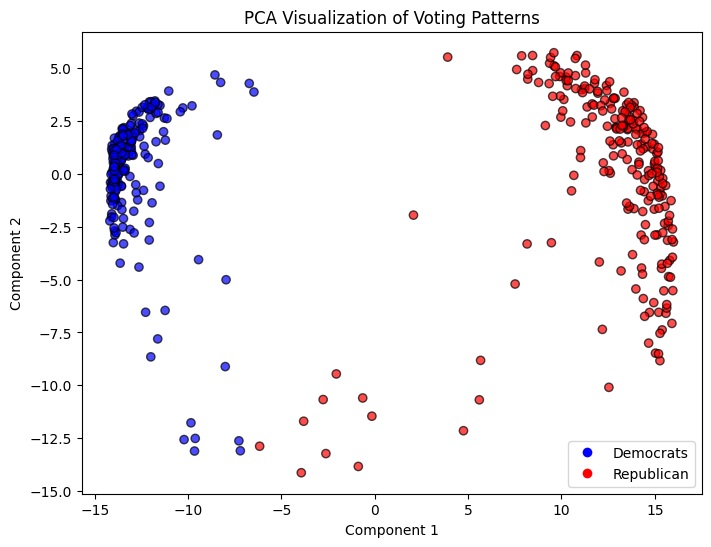

In [54]:
# Step 3: Get Party Information
person_to_party = {person: party for party, members in US_PP.items() for person in members}
party_colors = {100: 'blue', 200: 'red'}  # Assign colors

# Assign colors based on party
colors = [party_colors.get(person_to_party.get(person, -1), 'gray') for person in people]

# Step 4: Plot the Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(US_reduced_matrix[:, 0], US_reduced_matrix[:, 1], c=colors, alpha=0.7, edgecolors='k')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA Visualization of Voting Patterns")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrats'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican')])
plt.show()

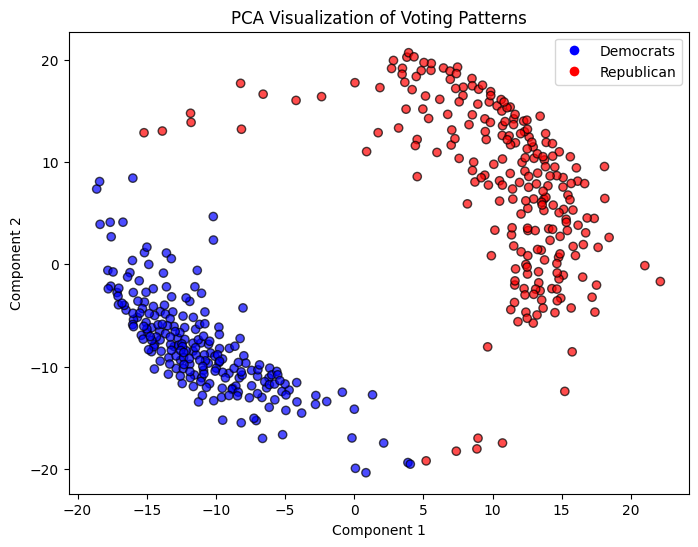

In [56]:
# Step 3: Get Party Information
person_to_party = {person: party for party, members in US_PP.items() for person in members}
party_colors = {100: 'blue', 200: 'red'}  # Assign colors

# Assign colors based on party
colors = [party_colors.get(person_to_party.get(person, -1), 'gray') for person in people]

# Step 4: Plot the Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(mds1, mds2, c=colors, alpha=0.7, edgecolors='k')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA Visualization of Voting Patterns")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrats'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican')])
plt.show()

In [22]:
people_array = np.array(people)

# Step 2: Get Boolean masks for Democrats and Republicans
democrat_mask = np.array([person_to_party.get(person, -1) == 100 for person in people])
republican_mask = np.array([person_to_party.get(person, -1) == 200 for person in people])

# Step 3: Extract PCA values
democrats_pca = US_reduced_matrix[democrat_mask]
republicans_pca = US_reduced_matrix[republican_mask]

# Step 4: Print the shape of extracted matrices
print(f"Democrats PCA Shape: {democrats_pca.shape}")
print(f"Republicans PCA Shape: {republicans_pca.shape}")

Democrats PCA Shape: (221, 2)
Republicans PCA Shape: (230, 2)


In [39]:
pc1 = US_reduced_matrix[:,0]
pc2 = US_reduced_matrix[:,1]

demo_pc1 = democrats_pca[:,0]
demo_pc2 = democrats_pca[:,1]

repo_pc1 = republicans_pca[:,0]
repo_pc2 = republicans_pca[:,1]

In [55]:
mds1 = mds[:,0]
mds2= mds[:,1]

demo_pc1 = democrats_pca[:,0]
demo_pc2 = democrats_pca[:,1]

repo_pc1 = republicans_pca[:,0]
repo_pc2 = republicans_pca[:,1]

In [24]:
cand = pd.read_csv("data/USA/H118_members.csv")

nom1 = cand["nominate_dim1"]
nom2 = cand["nominate_dim2"]

demo = cand[cand['party_code']==100]
repo = cand[cand['party_code']==200]


demo_nom1 = demo["nominate_dim1"]
demo_nom2 = demo['nominate_dim2']


repo_nom1 = repo["nominate_dim1"]
repo_nom2 = repo['nominate_dim2']


In [46]:
corr_score, p_value = pearsonr(pc1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(pc2, nom2)
print(corr_score, p_value)

-0.09870467148217349 0.036129264334289764
-0.019678495793856925 0.6768334036433638


In [57]:
corr_score, p_value = pearsonr(mds1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(mds2, nom2)
print(corr_score, p_value)

-0.0770174513498687 0.10236616899798692
0.009719333879712511 0.8369165072660587


In [29]:
corr_score, p_value = pearsonr(demo_pc1, demo_nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(demo_pc2, demo_nom2)
print(corr_score, p_value)

0.0060942920886535535 0.9282194867557861
0.047634528552310616 0.4811074642551481


In [30]:
corr_score, p_value = pearsonr(repo_pc1, repo_nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(repo_pc2, repo_nom2)
print(corr_score, p_value)

-0.09054364377962423 0.1711577144956217
0.0029471180077149696 0.9645442440343549


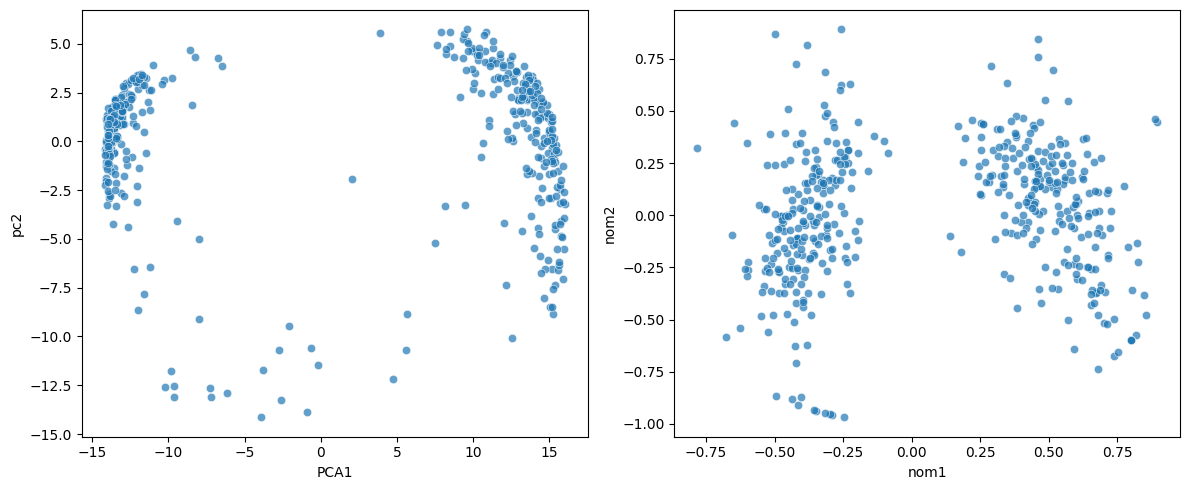

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=pc1, y=pc2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("pc2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=nom1, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("nom1")
axes[1].set_ylabel("nom2")


plt.tight_layout()
plt.show()


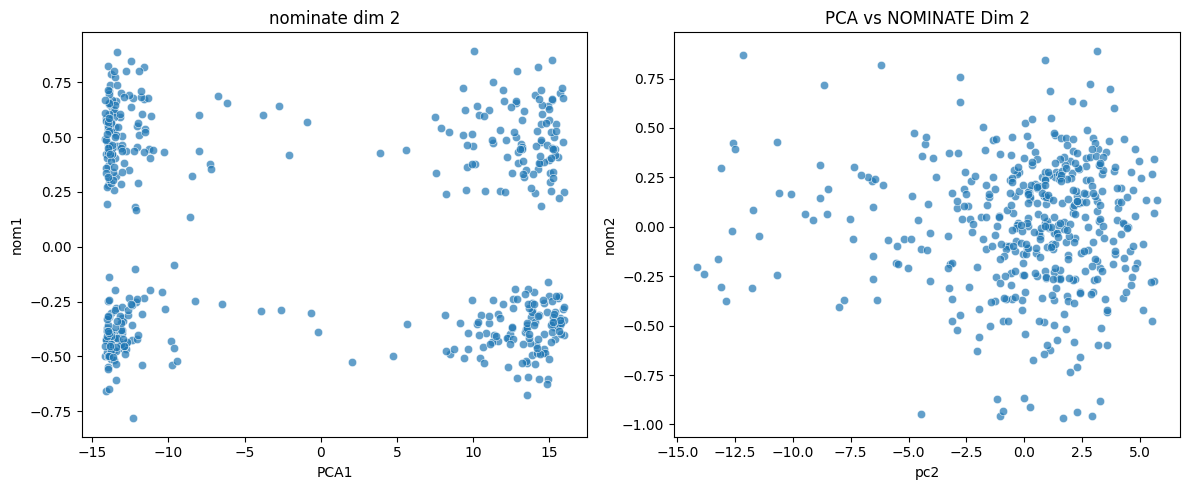

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=pc1, y=nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=pc2, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

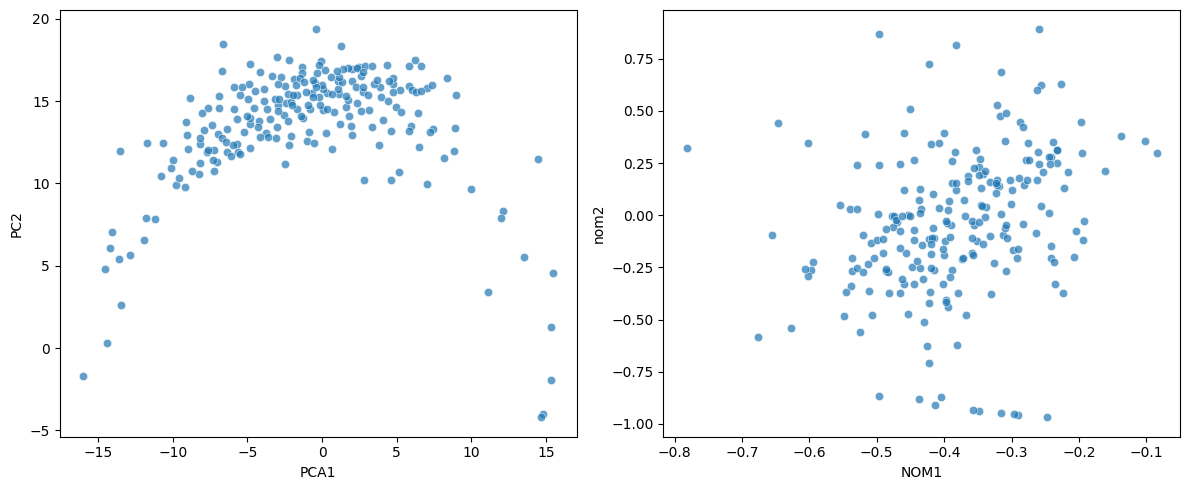

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=demo_pc1, y=demo_pc2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("PC2")


# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=demo_nom1, y=demo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("NOM1")
axes[1].set_ylabel("nom2")

plt.tight_layout()
plt.show()

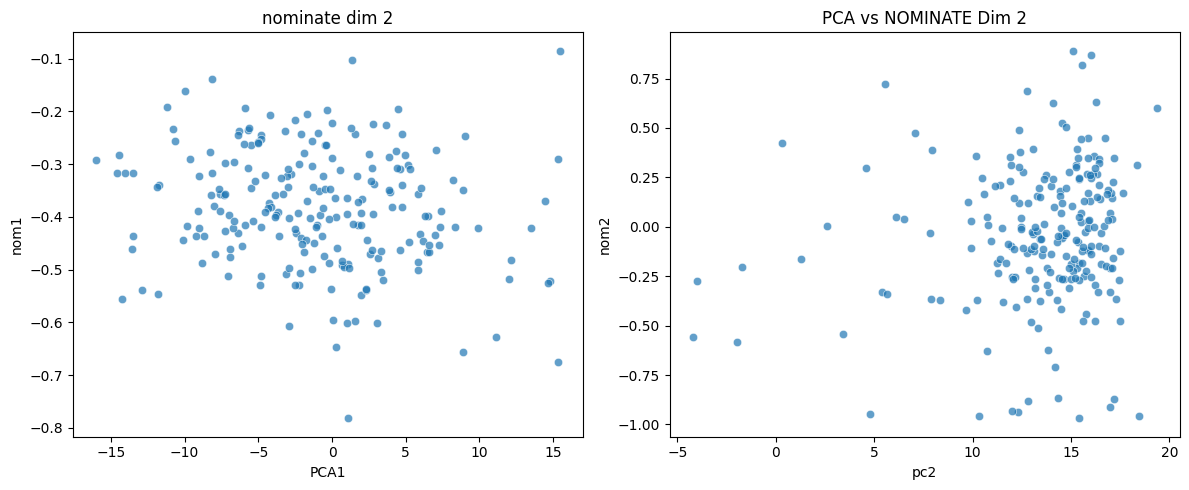

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=demo_pc1, y=demo_nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=demo_pc2, y=demo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

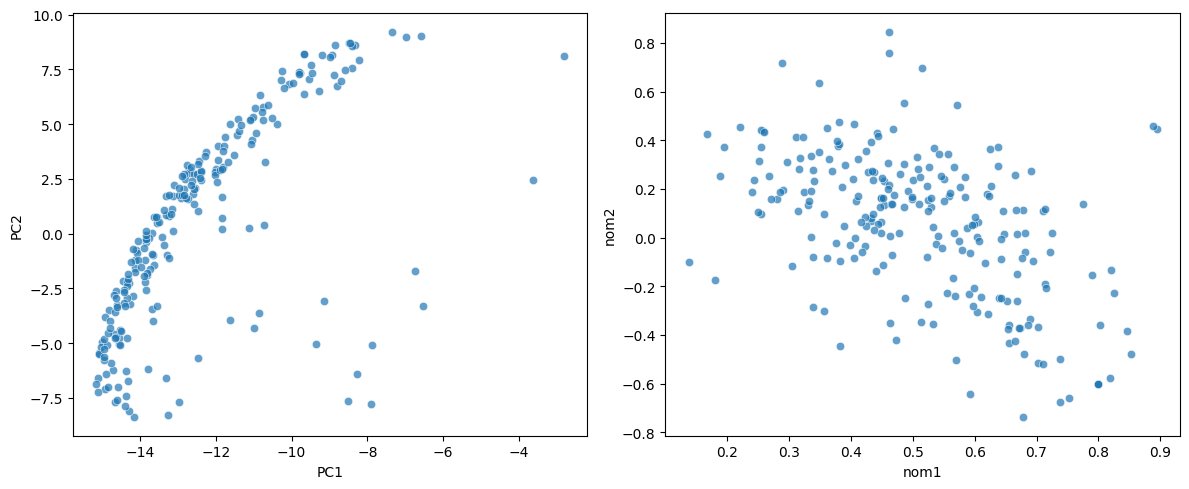

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=repo_pc1, y=repo_pc2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=repo_nom1, y=repo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("nom1")
axes[1].set_ylabel("nom2")

plt.tight_layout()
plt.show()

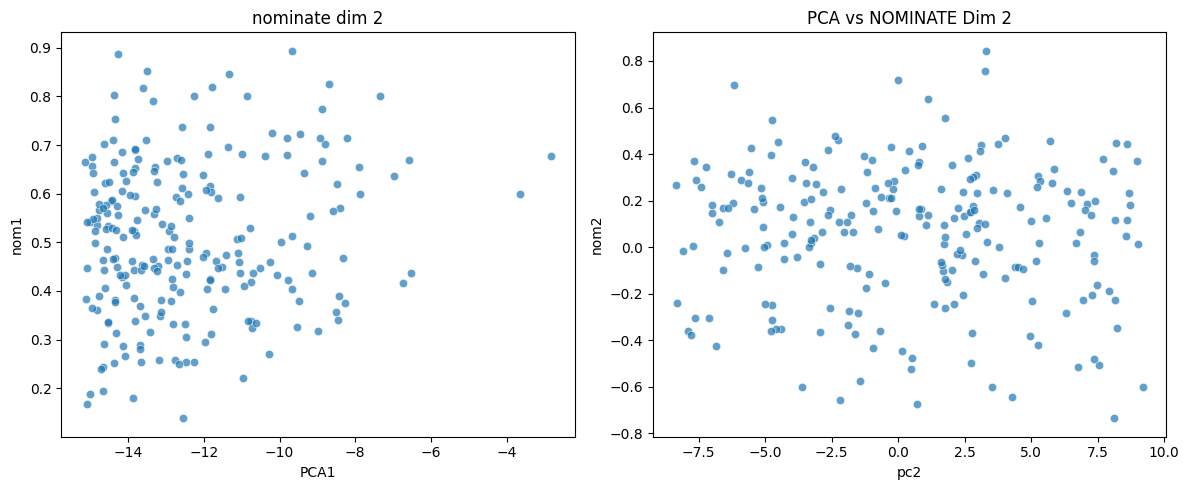

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=repo_pc1, y=repo_nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=repo_pc2, y=repo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

In [156]:
# Create UMAP model
umap_model = UMAP(n_components=2, random_state=42)  # Changed to uppercase UMAP
umap_result = umap_model.fit_transform(US_reduced_matrix)

/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
umap1 = umap_result[:,0]
umap2 = umap_result[:,1]

In [166]:
corr_score, p_value = pearsonr(umap1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(umap2, nom2)
print(corr_score, p_value)

0.08918592664588054 0.0584194951536898
0.03167994292709261 0.5021690890843878


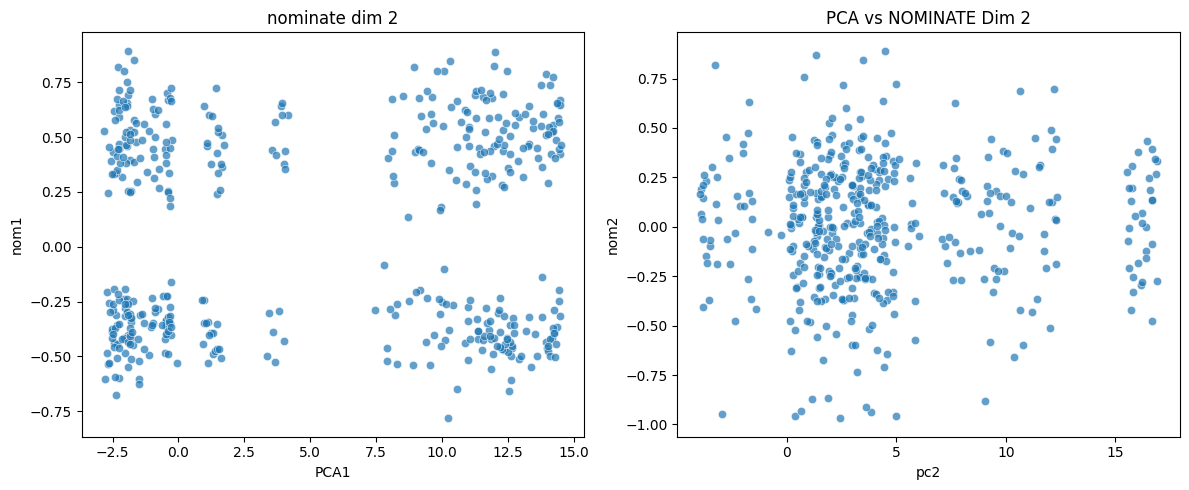

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=umap1, y=nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=umap2, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

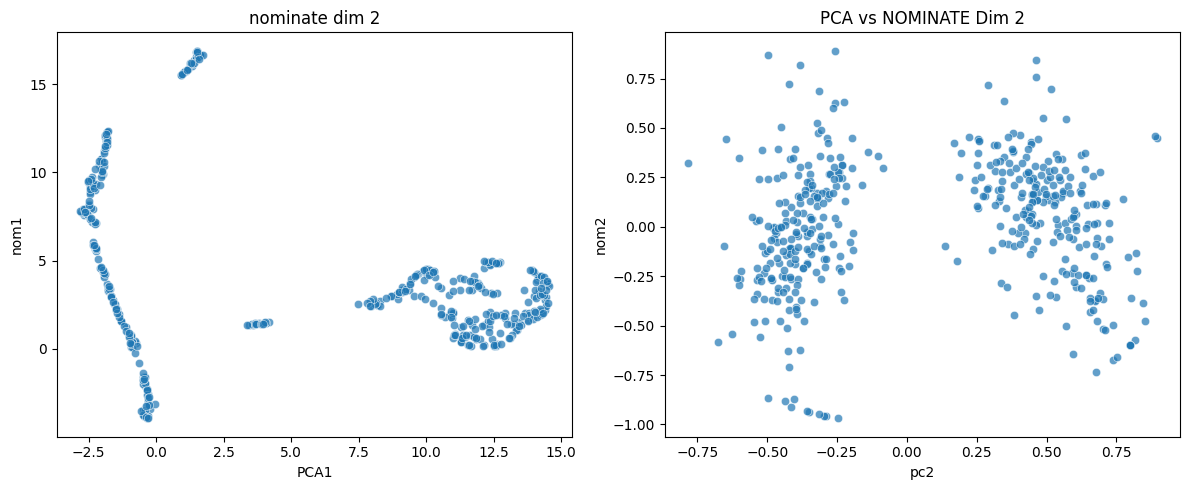

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=umap1, y=umap2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=nom1, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

In [161]:
# Create UMAP model
umap_model = UMAP(n_components=1, random_state=42)  # Changed to uppercase UMAP
umap_result = umap_model.fit_transform(D_reduced_matrix)

umap_result = 2 * (umap_result - np.min(umap_result)) / (np.max(umap_result) - np.min(umap_result)) - 1

# Step 3: Visualize UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_result, np.zeros_like(umap_result), c='blue', label="UMAP Projection")
plt.title("Denmark 1D UMAP Projection After PCA")
plt.xlabel("UMAP Component")
plt.yticks([])  # Hide y-axis ticks since it's 1D
plt.legend()
plt.show()

NameError: name 'D_reduced_matrix' is not defined